In [1]:
import numpy as np
import matplotlib.pyplot as plt
import utilities
import time, os

from tqdm import tqdm

plt.style.use('default')
params = {"ytick.color" : "black",
          "xtick.color" : "black",
          "axes.labelcolor" : "black",
          "axes.edgecolor" : "black",
          "text.usetex" : True,
          "font.family" : "serif",
          "font.serif" : ["Computer Modern Serif"],
          "font.size" : "20"
         }
plt.rcParams.update(params)


# Combinatorial bandit problem

## Definition of the different bandit problems and the algorithms

Combinatorial bandit Problem :

    -Two decisions Problem

Combinatorial bandit Algorithm for the Two decisions Problems :

    -ESCB
    -Beta-CTS
    -BG-CTS 

In [3]:
class CombinatorialSet:
    """The class implements the basic methode of combinatorial set
    """
    def __init__(self, d, distribution, params):
        """Init the k arm bandit problem

        Args:
            d (int): number of arms
            distribution (str): distribution of rewards
            params (array): parameters of the distribution, the line i contain the parameters of the distribution of the arm i
        """

        self.d = d
        self.distribution = distribution
        self.params = params
        if distribution == 'bernoulli':
            self.mus = params
            self.sigmas = 1/2*np.ones_like(params)
        if distribution == 'gaussian':
            self.mus = params[...,0]
            self.sigmas = params[...,1]
        self.shape = self.mus.shape


    def pull(self):
        """Pull the arms
        
        Returns:
            reward (float): reward of the arms
        """

        if self.distribution == 'bernoulli':
            return np.random.binomial(1,self.mus)
        if self.distribution == 'gaussian':
            return np.random.normal(self.mus, self.sigmas)

class Twosets(CombinatorialSet):
    def __init__(self, d, distribution, params):
        super().__init__(d, distribution, params)
        assert d%2 == 0, "d must be even"
        self.name = "twosets"
        self.m=d//2

        self.bestdecision = np.argmax([np.sum(self.mus[:self.m]), np.sum(self.mus[self.m:])])
        self.bestdecisionset = np.concatenate([np.ones(self.m)*(1-self.bestdecision), np.ones(self.m)*self.bestdecision])
        self.rewardmax = np.sum(self.mus*self.bestdecisionset)
        self.Deltamin = (self.mus[self.m] - self.mus[0])*self.m

In [4]:
bandit = Twosets(10, 'bernoulli', np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]))
print(bandit.m)
print(bandit.bestdecision)
print(bandit.bestdecisionset)
print(bandit.rewardmax)

5
1
[0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
4.0


In [5]:
def fbonuses(t, m, lamda = 0.01):
    if t < np.exp(1):
        t = np.exp(1)
    if lamda == 0:
        cst = 0
    else:
        cst = np.log(1+np.exp(1)/lamda)
    
    f = (1+lamda)* 2 * (np.log(t) + (m+2)*np.log(np.log(t)) + m/2 * cst )

    return f

def gbonuses(t, m , lamda = 0.01):
    f = fbonuses(t, m, lamda)
    if t < 2:
        l = 1
    else:
        l = np.log(t)
    return f/l


def ESCBbonus(t, muhats, indexes, N, lamda = 0.01, sigma = 1):
    """Compute the ESCB 

    Args:
        t (int): time step
        muhats (array): empirical mean of the arms
        indexes (array): indexes of the arms
        N (array): number of time each has been played
        lambda (float): parameter of the algorithm

    Returns:
        bonus : the upper confidence bound for that decision
    """
    m = np.sum(indexes)
    f = fbonuses(t, m, lamda)
    
    return np.sum(muhats[indexes]) + sigma*np.sqrt(f*np.sum(1/N[indexes])) #same sigma for all arms


In [6]:
class cbanditsAlgo:
    """This class implements the combinatorial bandit problem    
    attributes:

    methods:
    
    """
    def __init__(self, combinatorialset, policy, algoparams = None, prior = "uniform"):
        """

        args:
            combinatorialset: the combinatorial set to be used (Mset, matching, twosets, path )
            policy: the policy to be used (TS, TSg, UCB, egreedy, excommit)
            algoparam : the parameters of the algorithm
            prior: the prior to be used (uniform, beta, gaussian) I may put this on the algo parmeters

        Attributes:
            d (int): number of arms:
            self.muhats (array): estimated mean of the arms
            t (int): time step
            w (array): number of time an arm is played
            regrets (list) : regret at each time step
            policy (str): policy to use
            algoparams (dict): parameters of the policy.

        """

        assert combinatorialset.name == "twosets", f"Only twosets are implemented for now"

        # get the parameters of the combinatorial arm bandit problem
        self.cbandits = combinatorialset
        self.d = combinatorialset.d
        self.m = combinatorialset.m
        self.shape = combinatorialset.shape
        self.name = combinatorialset.name
        

        self.bestdecisionset = combinatorialset.bestdecisionset
        self.mus = combinatorialset.mus
        self.sigmas = combinatorialset.sigmas
        self.distribution = combinatorialset.distribution
        self.rewardmax = combinatorialset.rewardmax
        

        # store in the class the policy and the initial parameters
        self.policy = policy
        self.algoparams = algoparams
        self.prior = prior

        self.reset()
    
    def reset(self):
        # initialise the paramater of the algorithm
        self.regrets = []
        self.muhats = np.zeros(self.d)
        # small hack to avoid division by 0 before the arm is played for the first time
        self.t = 1
        self.N = np.ones(self.shape) * 10**(-8)

        if self.policy == 'epsilon-greedy':
            self.explore = self.algoparams["explore"]
        if self.policy == "explore-commit":
            self.explore = self.algoparams["explore"]
        if self.policy == 'cucb' or self.policy == 'escb':
            self.sigmasalgo = self.algoparams["sigmas"]
            self.sigma = np.max(self.sigmasalgo)
            self.lamda = self.algoparams["lambda"]
        if self.policy == 'thompson-sampling':
            self.theta = np.zeros_like(self.mus)
            if self.distribution == 'bernoulli':
                if self.prior == "beta":
                    self.alphas = self.algoparams["prior"][...,0].copy()
                    self.betas = self.algoparams["prior"][...,1].copy()
                if self.prior == "uniform":
                    self.alphas = np.ones(self.shape)
                    self.betas = np.ones(self.shape)
                if self.prior == "gaussian":
                    # In the case of a gaussian prior for bernoulli distribution we assume that the prior is uniform on R
                    # And that the bernoulli are gaussian with variance 1/4 
                    self.muhats = np.ones(self.shape)/2
                    self.sigmapost = 10**8 * np.ones(self.shape)
                    self.sigmasalgo = self.algoparams["sigma"]
                    self.lamda = self.algoparams["lambda"]
                if self.prior == "jeffrey":
                    self.alphas = np.ones(self.shape)/2
                    self.betas = np.ones(self.shape)/2

            if self.distribution == 'gaussian':
                self.sigmasalgo = self.algoparams["sigmas"]
                if self.prior == "gaussian":
                    self.muhats = self.algoparams["prior"][...,0].copy()
                    self.sigmapost = self.algoparams["prior"][...,1].copy()
                if self.prior == "uniform" or self.prior == "jeffrey":
                    self.muhats = np.zeros(self.shape)
                    self.sigmapost = 10**8 * np.ones(self.shape)
                if self.prior == "centered":
                    self.muhats = np.zeros(self.shape)
                    self.sigmapost = np.ones(self.shape)
            
        if self.policy == "SG-TS": 
            self.sigmasalgo = self.algoparams["sigmas"]
            self.lamda = self.algoparams["lambda"]
            if self.prior == "gaussian":
                    self.muhats = self.algoparams["prior"][...,0].copy()
                    self.sigmapost = self.algoparams["prior"][...,1].copy()
            if self.prior == "uniform" or self.prior == "jeffrey":
                    self.muhats = np.zeros(self.shape)
                    self.sigmapost = 10**8 * np.ones(self.shape)
            if self.prior == "centered":
                    self.muhats = np.zeros(self.shape)
                    self.sigmapost = np.ones(self.shape)
                    
        if self.policy == "thompson-sampling-adv":
            self.bonus = self.algoparams["bonus"]
            self.lambd = self.algoparams["lambda"]
            self.delta = self.algoparams["delta"]
            self.theta = np.zeros_like(self.mus)
            if self.distribution == 'bernoulli':
                if self.prior == "beta":
                    pass
                if self.prior == "uniform":
                    pass
                if self.prior == "gaussian":
                    self.rewardsum = np.zeros(self.shape)
                    self.muhats = np.zeros(self.shape)
                    self.cov = self.lambd * np.eye(self.shape)
                    self.sigmapost = np.linalg.inv(self.cov)   
            if self.distribution == 'gaussian':
                if self.prior == "gaussian":
                    # TODO Non centered case
                    pass
                    # self.muhats = self.algoparams["prior"][...,0].copy()
                    # self.sigmapost = self.algoparams["prior"][...,1].copy()
                if self.prior == "centered":
                    self.rewardsum = np.zeros(self.shape)
                    self.muhats = np.zeros(self.shape)
                    self.covinv= self.lambd * np.eye(self.d)
                    self.covpost = np.linalg.inv(self.covinv)
    

    def select(self):
        """Select the arm to pull according to the algorithm policy
        
        Returns:
            index (int): index of the arm to pull
        """
        if self.policy == 'epsilon-greedy':
            if self.t == 1:
                if self.name == "twosets":
                    # so each decision can be played first with equal probability
                    self.bestdecision = np.random.randint(2)
                    indexes = np.concatenate([np.ones(self.m,dtype=int)*(1-self.bestdecision), np.ones(self.m,dtype=int)*self.bestdecision])
                    return indexes
            if np.random.rand() < self.explore:
                if self.name == "twosets":
                    self.bestdecision = np.random.randint(2)
                    indexes = np.concatenate([np.ones(self.m,dtype=int)*(1-self.bestdecision), np.ones(self.m,dtype=int)*self.bestdecision])
            else:
                if self.name == "twosets":
                    self.bestdecision = np.argmax([np.sum(self.muhats[:self.m]), np.sum(self.muhats[self.m:])])
                    indexes = np.concatenate([np.ones(self.m,dtype=int)*(1-self.bestdecision), np.ones(self.m,dtype=int)*self.bestdecision])
            return indexes
        if self.policy == 'explore-commit':
            if (self.N < self.explore).any():
                if self.name == "twosets":
                    self.bestdecision = np.argmax(self.N < self.explore)
                    if self.bestdecision >= self.m:
                        self.bestdecision = 1
                    else:
                        self.bestdecision = 0
                    indexes = np.concatenate([np.ones(self.m,dtype=int)*(1-self.bestdecision), np.ones(self.m,dtype=int)*self.bestdecision])
            else:
                if self.name == "twosets":
                    self.bestdecision = np.argmax([np.sum(self.muhats[:self.m]), np.sum(self.muhats[self.m:])])
                    indexes = np.concatenate([np.ones(self.m,dtype=int)*(1-self.bestdecision), np.ones(self.m,dtype=int)*self.bestdecision])
            return indexes
        

        if self.policy == 'cucb':
            self.optimistbound = self.muhats+self.sigmasalgo*np.sqrt(1.5*np.log(self.t)/self.N)
            
            if self.name == "twosets":
                self.bestdecision = np.argmax([np.sum(self.optimistbound[:self.m]), np.sum(self.optimistbound[self.m:])])
                indexes = np.concatenate([np.ones(self.m,dtype=int)*(1-self.bestdecision), np.ones(self.m,dtype=int)*self.bestdecision])
            return indexes  
        
        if self.policy == 'escb':
            # self.optimistbound = self.muhats+self.c*np.sqrt(np.log(self.t)/2/self.N)/np.sqrt(self.m) # True ESCB index
            ind1 = np.concatenate([np.ones(self.m,dtype=int), np.zeros(self.m,dtype=int)])
            ind2 = np.concatenate([np.zeros(self.m,dtype=int), np.ones(self.m,dtype=int)])
            if self.name == "twosets":
                self.bestdecision = np.argmax([ESCBbonus(self.t, self.muhats, ind1, self.N, lamda = self.lamda, sigma = self.sigma), ESCBbonus(self.t, self.muhats, ind2, self.N, lamda = self.lamda, sigma = self.sigma)])
                indexes = np.concatenate([np.ones(self.m,dtype=int)*(1-self.bestdecision), np.ones(self.m,dtype=int)*self.bestdecision])
            return indexes

        
        if self.policy == 'thompson-sampling':
            if ((self.prior == 'beta' or self.prior == 'uniform' or self.prior == "jeffrey") and (self.distribution == 'bernoulli')):
                self.theta = np.random.beta(self.alphas, self.betas)
                if self.name == "twosets":
                    self.bestdecision = np.argmax([np.sum(self.theta[:self.m]), np.sum(self.theta[self.m:])])
                    indexes = np.concatenate([np.ones(self.m,dtype=int)*(1-self.bestdecision), np.ones(self.m,dtype=int)*self.bestdecision])
            if (self.prior == 'gaussian' or self.prior == 'centered' or self.prior == 'uniform' or self.prior == "jeffrey") and (self.distribution == 'gaussian'):
                self.theta = np.random.normal(self.muhats, np.sqrt(1+self.lamda) * self.sigmapost)
                if self.name == "twosets":
                    self.bestdecision = np.argmax([np.sum(self.theta[:self.m]), np.sum(self.theta[self.m:])])
                    indexes = np.concatenate([np.ones(self.m,dtype=int)*(1-self.bestdecision), np.ones(self.m,dtype=int)*self.bestdecision])
            return indexes  
        
        if self.policy == 'SG-TS':
            self.theta = np.random.normal(self.muhats, np.sqrt(gbonuses(self.t, self.m, lamda = self.lamda))  * self.sigmapost)
            if self.name == "twosets":
                self.bestdecision = np.argmax([np.sum(self.theta[:self.m]), np.sum(self.theta[self.m:])])
                indexes = np.concatenate([np.ones(self.m,dtype=int)*(1-self.bestdecision), np.ones(self.m,dtype=int)*self.bestdecision])

        # if self.policy == 'thompson-sampling-adv':
        #     ### TODO
        #     # if self.prior == 'bernoulli' or self.prior == 'uniform':
        #     #     theta = np.random.beta(self.alphas, self.betas)
        #     #     if self.name == "twosets":
        #     #         self.bestdecision = np.argmax([np.sum(theta[:self.m]), np.sum(theta[self.m:])])
        #     #         indexes = np.concatenate([np.ones(self.m)*(1-self.bestdecision), np.ones(self.m)*self.bestdecision])
        #     if self.prior == 'gaussian' or self.prior == 'centered':
        #         error = 0
        #         for i in range(11):
        #             try:
        #                 self.theta = np.random.multivariate_normal(self.muhats, self.bonus**2 * self.d * 9 * np.log(self.t/self.delta) * self.covpost)
        #             except np.linalg.LinAlgError as e:
        #                 error += 1
        #                 if error >= 11:
        #                     print("error")
        #             else:
        #                 break
        #         if self.name == "twosets":
        #             self.bestdecision = np.argmax([np.sum(self.theta[:self.m]), np.sum(self.theta[self.m:])])
        #             indexes = np.concatenate([np.ones(self.m,dtype= int)*(1-self.bestdecision), np.ones(self.m,dtype=int)*self.bestdecision])

            return indexes
        
    def update(self, indexes, rewards):
        """Update the policy
        
        Args:
            indexes : array: indexes of the arms to pull
            rewards : list of all the rewards of ALL arm
        """
        self.t += 1
        
        if (self.N[indexes == 1] < 0.5).any():
            # correct the hack to avoid division by 0
            self.N[(indexes == 1) & (self.N < 0.5)] = 1
            self.N[(indexes == 1) & (1-(self.N < 0.5))] += 1
        else:
            self.N[indexes==1] += 1

        if self.policy == 'epsilon-greedy':
            self.muhats[indexes==1] = (self.muhats[indexes==1] * (self.N[indexes==1] - 1) + rewards[indexes == 1]) / self.N[indexes==1]
        if self.policy == 'explore-commit':
            self.muhats[indexes==1] = (self.muhats[indexes==1] * (self.N[indexes==1] - 1) + rewards[indexes == 1]) / self.N[indexes==1]

        if self.policy == "cucb":
            self.muhats[indexes==1] = (self.muhats[indexes==1] * (self.N[indexes==1] - 1) + rewards[indexes == 1]) / self.N[indexes==1]
        if self.policy == "escb":
            self.muhats[indexes==1] = (self.muhats[indexes==1] * (self.N[indexes==1] - 1) + rewards[indexes == 1]) / self.N[indexes==1]

        if self.policy == 'thompson-sampling':
            if self.distribution == 'bernoulli':
                if self.prior == 'beta' or self.prior == 'uniform' or self.prior == 'jeffrey':
                    self.alphas[indexes==1] += rewards[indexes == 1]
                    self.betas[indexes==1] += 1 - rewards[indexes == 1]
                if self.prior == 'gaussian' or self.prior == 'centered':
                    sigmaprev = self.sigmapost.copy()
                    self.sigmapost[indexes==1] = np.sqrt((1/self.sigmapost[indexes==1]**2 + 1/self.sigmasalgo[indexes == 1]**2))**-1
                    self.muhats[indexes==1] = self.sigmapost[indexes == 1]**2 * (self.muhats[indexes == 1] / sigmaprev[indexes==1]**2 + rewards[indexes == 1] / self.sigmasalgo[indexes == 1]**2)

            if self.distribution == 'gaussian':
                sigmaprev = self.sigmapost.copy()
                self.sigmapost[indexes==1] = np.sqrt((1/self.sigmapost[indexes==1]**2 + 1/self.sigmas[indexes == 1]**2))**-1
                self.muhats[indexes==1] = self.sigmapost[indexes == 1]**2 * (self.muhats[indexes == 1] / sigmaprev[indexes==1]**2 + rewards[indexes == 1] / self.sigmasalgo[indexes == 1]**2)
                    
        if self.policy == 'SG-TS':
                sigmaprev = self.sigmapost.copy()
                self.sigmapost[indexes==1] = np.sqrt((1/self.sigmapost[indexes==1]**2 + 1/self.sigmas[indexes == 1]**2))**-1
                self.muhats[indexes==1] = self.sigmapost[indexes == 1]**2 * (self.muhats[indexes == 1] / sigmaprev[indexes==1]**2 + rewards[indexes == 1] / self.sigmasalgo[indexes == 1]**2)


        if self.policy == 'thompson-sampling-adv':
            ### TODO: Make it online so that we dont have to compute the inverse all the time woodbury etc
            ### TODO: implement the update for bernoulli adverserial case
            ### TODO implement the non centered case
            if self.distribution == 'bernoulli':
            #     if self.prior == 'beta' or self.prior == 'uniform':
            #         self.alphas[indexes==1] += rewards[indexes == 1]
            #         self.betas[indexes==1] += 1 - rewards[indexes == 1]
                if self.prior == 'gaussian':
                    self.rewardsum += indexes * np.sum(rewards[indexes == 1])
                    self.covinv += np.outer(indexes,indexes)
                    self.cov = np.linalg.inv(self.covinv)
                    self.muhats = self.covpost@self.rewardsum
            if self.distribution == 'gaussian':
                # TODO expend it to other cases
                    self.rewardsum += indexes * np.sum(rewards[indexes == 1])
                    self.covinv += np.outer(indexes,indexes)
                    self.covpost = np.linalg.inv(self.covinv)
                    self.muhats = self.covpost@self.rewardsum

        self.regrets.append(self.rewardmax - np.sum(self.mus[indexes==1]))



## Cumulative Regret Experiment For Bernoulli arms

In [7]:
# test the code

d = 100
m = d//2
T = 20000
N = 100
# create a d arm bandit problem
problem = Twosets(d, distribution = 'bernoulli', params=np.array([0.7 if i < m else 0.9 for i in range(d)]))

# initialise the algorithms



paramsdict = {}

params = {"T" : T
}

cTSbetajeff = cbanditsAlgo(problem, "thompson-sampling", algoparams =  params, prior = "jeffrey")
paramsdict["CTS-Beta-Jeffreys"] = params

params = {"T" : T
}

cTSbetau = cbanditsAlgo(problem, "thompson-sampling", algoparams =  params, prior = "uniform")
paramsdict["CTS-Beta-Uniform"] = params

params = {"sigmas" : np.ones(d)/2,
          "T" : T,
          "lambda" : 0}

# cUCB = cbanditsAlgo(problem, "cucb", algoparams={'c' : 1})
# paramsdict["cUCB"] = params
escb = cbanditsAlgo(problem, "escb", algoparams= params)
paramsdict["ESCB"] = params



params = {"sigmas" : np.ones(d)/2,
          "T" : T,
          "lambda" : 0}

SGTS = cbanditsAlgo(problem, "SG-TS", algoparams= params)
paramsdict["SG-CTS"] = params

# params = {"explore" : 2*(np.sqrt(d/2))/(0.1*d/2)**2/T,  "T" : T}
# egreedy = cbanditsAlgo(problem, "epsilon-greedy", algoparams=params)
# paramsdict["egreedy"] = params

# params = {"explore" : np.max([(np.sqrt(d/2)) * np.log(T*(d/2*0.1)**2/(d/2))/((d/2*0.1)**2),1])}
# excommit = cbanditsAlgo(problem, "explore-commit", algoparams=params)
# paramsdict["excommit"] = params

cTSbetajeffregrets = np.zeros((N,T))
cTSbetauregrets = np.zeros((N,T))
# cTSgregrets = np.zeros((N,T))
# cTSadvregrets = np.zeros((N,T))
# cUCBregrets = np.zeros((N,T))
escbregrets = np.zeros((N,T))
# egreedyregrets = np.zeros((N,T))
# excommitregrets = np.zeros((N,T))
SGTSregrets = np.zeros((N,T))

for k in tqdm(range(N)):
    print(f"iteration {k}")
    for i in range(T):

        rewards = problem.pull()

        indexes = cTSbetajeff.select()
        cTSbetajeff.update(indexes, rewards)

        indexes = cTSbetau.select()
        cTSbetau.update(indexes, rewards)

        indexes = escb.select() 
        escb.update(indexes, rewards)

        indexes = SGTS.select()
        SGTS.update(indexes, rewards)
        
        # indexes = cTSg.select()
        # cTSg.update(indexes, rewards)

        # indexes = cTSadv.select()
        # cTSadv.update(indexes, rewards)

        # indexes = cUCB.select()
        # cUCB.update(indexes, rewards)

        # indexes = egreedy.select()
        # egreedy.update(indexes, rewards)

        # indexes = excommit.select()
        # excommit.update(indexes, rewards)


    cTSbetajeffregrets[k] = cTSbetajeff.regrets.copy()
    cTSbetauregrets[k] = cTSbetau.regrets.copy()
    # cTSgregrets[k] = cTSg.regrets.copy()
    # cTSadvregrets[k] = cTSadv.regrets.copy()
    SGTSregrets[k] = SGTS.regrets.copy()
    # cUCBregrets[k] = cUCB.regrets.copy() 
    escbregrets[k] = escb.regrets.copy()
    # egreedyregrets[k] = egreedy.regrets.copy()
    # excommitregrets[k] = excommit.regrets.copy()

    print("cTSbetajeff regret: ", np.sum(cTSbetajeff.regrets))
    print("cTSbetau regret: ", np.sum(cTSbetau.regrets))
    # print("cTSg regret: ", np.sum(cTSg.regrets))
    # print("cTSadv regret: ", np.sum(cTSadv.regrets))
    # print("cUCB regret: ", np.sum(cUCB.regrets))
    print("escb regret: ", np.sum(escb.regrets))
    # print("egreedy regret: ", np.sum(egreedy.regrets))
    # print("excommit regret: ", np.sum(excommit.regrets))
    print("SGTS regret: ", np.sum(SGTS.regrets))
    cTSbetajeff.reset()
    cTSbetau.reset()
    # cTSg.reset()
    # cTSadv.reset()
    # cUCB.reset()
    escb.reset()
    # egreedy.reset()
    # excommit.reset()
    SGTS.reset()

         

  0%|          | 0/100 [00:00<?, ?it/s]

iteration 0


  1%|          | 1/100 [00:03<06:01,  3.65s/it]

cTSbetajeff regret:  0.0
cTSbetau regret:  199999.99999999994
escb regret:  159.9999999999999
SGTS regret:  449.9999999999997
iteration 1


  2%|▏         | 2/100 [00:07<06:00,  3.67s/it]

cTSbetajeff regret:  0.0
cTSbetau regret:  199999.99999999994
escb regret:  179.9999999999999
SGTS regret:  399.9999999999997
iteration 2


  3%|▎         | 3/100 [00:11<05:56,  3.67s/it]

cTSbetajeff regret:  0.0
cTSbetau regret:  199999.99999999994
escb regret:  89.99999999999994
SGTS regret:  439.9999999999997
iteration 3


  4%|▍         | 4/100 [00:14<05:55,  3.70s/it]

cTSbetajeff regret:  199999.99999999994
cTSbetau regret:  199999.99999999994
escb regret:  299.9999999999998
SGTS regret:  459.99999999999966
iteration 4


  5%|▌         | 5/100 [00:18<05:52,  3.71s/it]

cTSbetajeff regret:  0.0
cTSbetau regret:  199999.99999999994
escb regret:  59.99999999999996
SGTS regret:  389.9999999999998
iteration 5


  6%|▌         | 6/100 [00:22<05:51,  3.74s/it]

cTSbetajeff regret:  199999.99999999994
cTSbetau regret:  199999.99999999994
escb regret:  239.99999999999983
SGTS regret:  409.9999999999998
iteration 6


  7%|▋         | 7/100 [00:26<05:47,  3.74s/it]

cTSbetajeff regret:  0.0
cTSbetau regret:  9.999999999999993
escb regret:  79.99999999999994
SGTS regret:  399.9999999999997
iteration 7


  7%|▋         | 7/100 [00:28<06:24,  4.14s/it]


KeyboardInterrupt: 

In [29]:
regretsdict1 =  {
        #  "cTSg" : cTSgregrets,
        #  "cTSadv" : cTSadvregrets,
        #  "cUCB" : cUCBregrets,
        #  "egreedy" : egreedyregrets,
        #  "excommit" : excommitregrets
        "B-CTS-Jeffreys" : cTSbetajeffregrets.copy(),
        "B-CTS-Uniform" : cTSbetauregrets.copy(),
        "ESCB" : escbregrets.copy(),
        "BG-CTS" : SGTSregrets.copy()
        }

In [66]:
regretsdictal =  {
        #  "cTSg" : cTSgregrets,
        #  "cTSadv" : cTSadvregrets,
        #  "cUCB" : cUCBregrets,
        #  "egreedy" : egreedyregrets,
        #  "excommit" : excommitregrets
        "B-CTS-Jeffreys" : regretsdict1["CTS-Beta-Jeffreys"],
        "B-CTS-Uniform" : regretsdict1["CTS-Beta-Uniform"],
        "ESCB" : regretsdict1["ESCB"],
        "BG-CTS" : regretsdict1["SG-CTS"]
        }

In [ ]:
#  Creating a test function to test the algorithms

def testalgo(algos, paramsdict, problem, T, N):
    pass

In [44]:
import importlib
importlib.reload(utilities)

<module 'utilities' from '/home/zhang/Bureau/cbandits/utilities.py'>

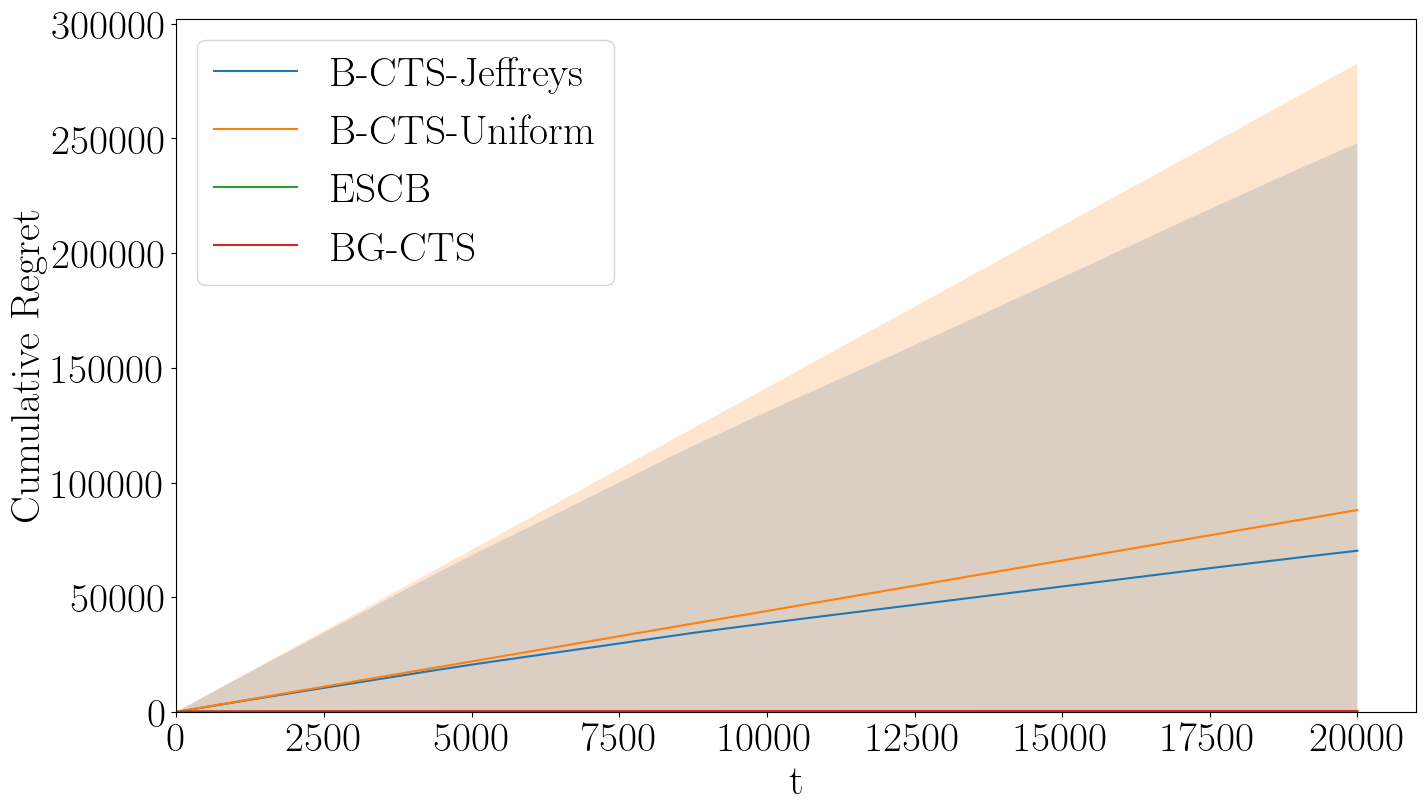

In [67]:
utilities.plot_regret(regretsdictal, save = False, paramsdict = paramsdict, banditenv = problem, mode = 1)

In [24]:
regretsdict2 =  {}
regretsdict2["escb"] = regretsdict["escb"]
regretsdict2["SGTS"] = regretsdict["SGTS"]

paramsdict2 = {}
paramsdict2["escb"] = paramsdict["escb"]
paramsdict2["SGTS"] = paramsdict["SGTS"]

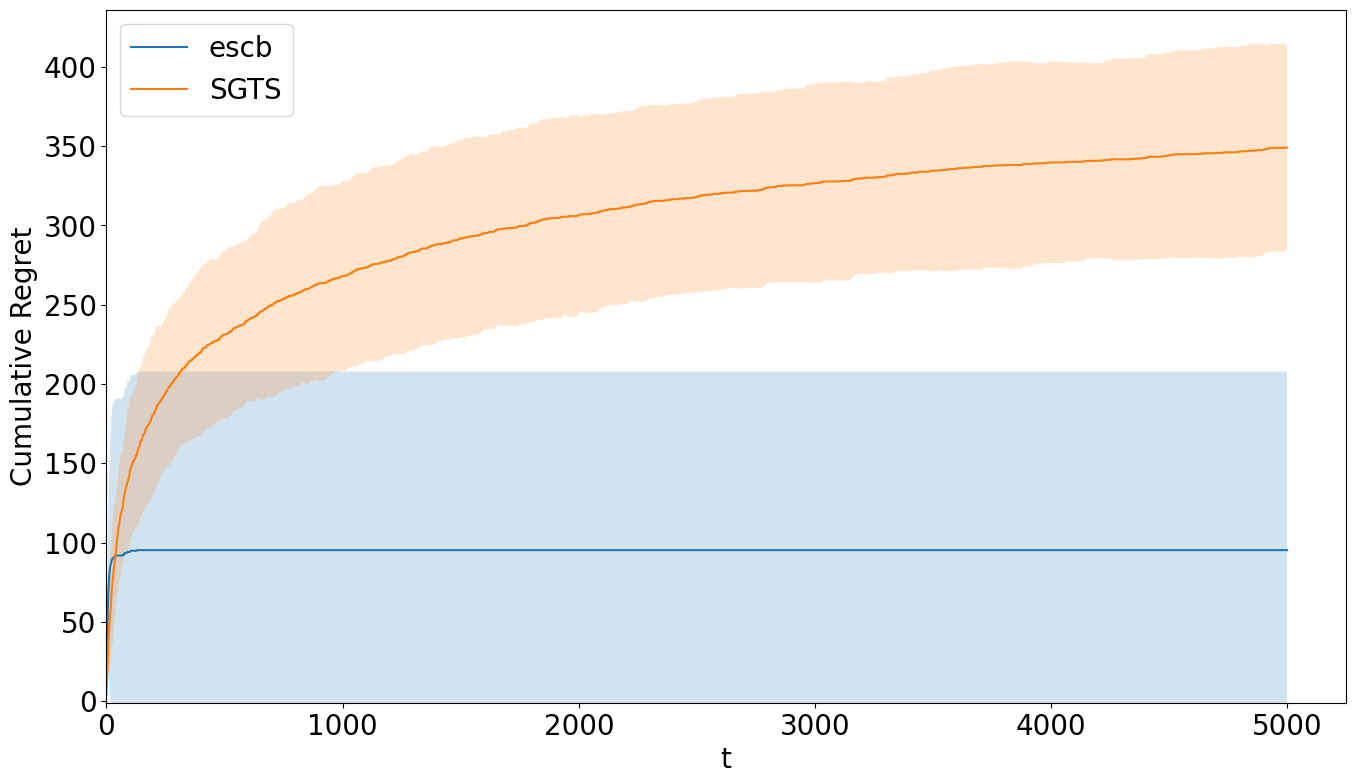

In [25]:
utilities.plot_regret(regretsdict2, save = False, paramsdict = paramsdict2, banditenv = problem, mode = 1)

In [26]:
regretsdict3 =  {}
regretsdict3["cTSbetajeff"] = regretsdict["cTSbetajeff"]
regretsdict3["cTSbetau"] = regretsdict["cTSbetau"]

paramsdict3 = {}
paramsdict3["cTSbetajeff"] = paramsdict["cTSbetajeff"]
paramsdict3["cTSbetau"] = paramsdict["cTSbetau"]

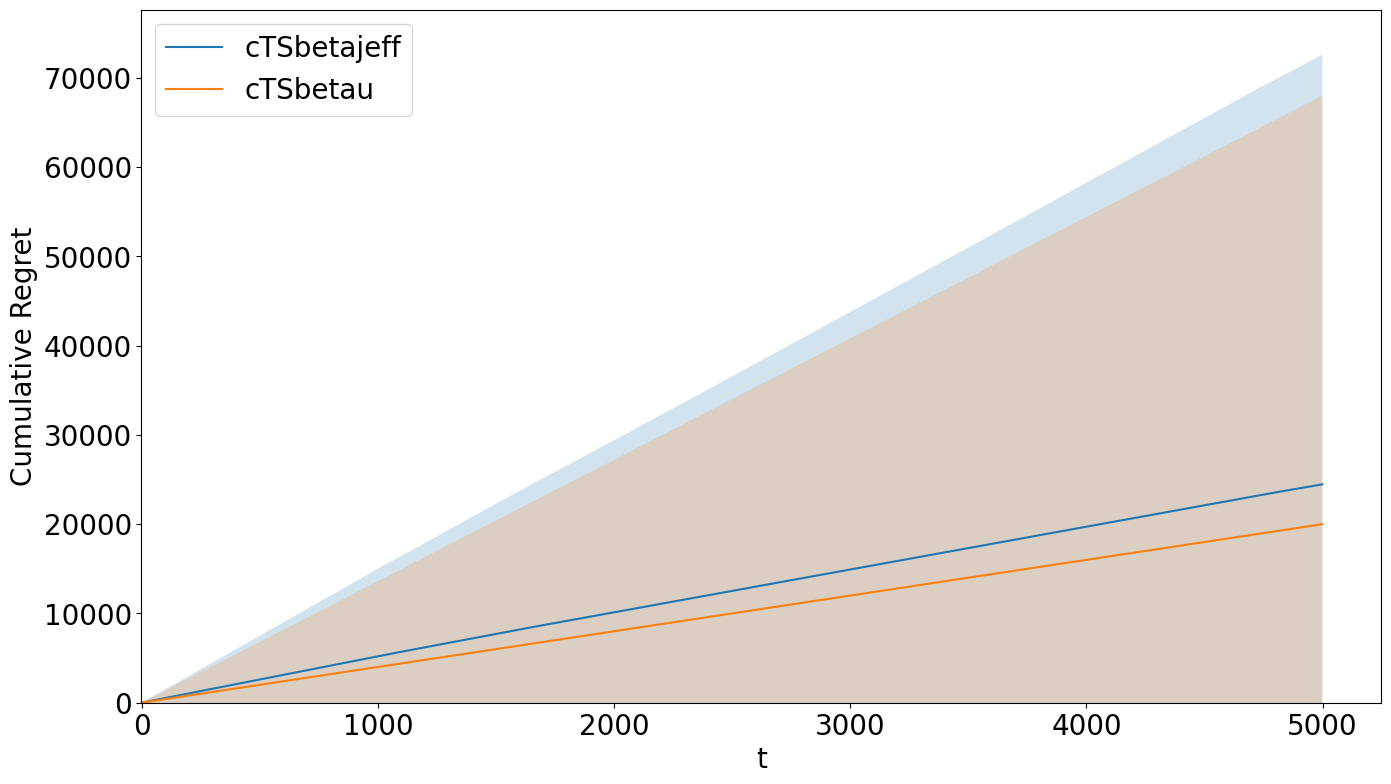

In [27]:
utilities.plot_regret(regretsdict3, save = False, paramsdict = paramsdict2, banditenv = problem, mode = 1)

## Bernoulli Regret dependence in the dimension d.

In [31]:
# test the code
ds = [10,50,90,130]
lend =len(ds)
T = 10000
N = 150

cTSbetajeffregrets = np.zeros((lend,N,T))
cTSbetauregrets = np.zeros((lend,N,T))
escbregrets = np.zeros((lend,N,T))
SGTSregrets = np.zeros((lend,N,T))


di =  0

for d in tqdm(ds):
    m = d//2

    # create a d arm bandit problem
    problem = Twosets(d, distribution = 'bernoulli', params=np.array([0.7 if i < m else 0.9 for i in range(d)]))

    # initialise the algorithms
    paramsdict = {}

    params = {"T" : T}
    cTSbetajeff = cbanditsAlgo(problem, "thompson-sampling", algoparams =  params, prior = "jeffrey")
    paramsdict["CTSbetajeff"] = params

    params = {"T" : T}
    cTSbetau = cbanditsAlgo(problem, "thompson-sampling", algoparams =  params, prior = "uniform")
    paramsdict["cTSbetau"] = params

    params = {"sigmas" : np.ones(d)/2,
            "T" : T,
            "lambda" : 0}
    escb = cbanditsAlgo(problem, "escb", algoparams= params)
    paramsdict["escb"] = params


    params = {"sigmas" : np.ones(d)/2,
            "T" : T,
            "lambda" : 0}
    SGTS = cbanditsAlgo(problem, "SG-TS", algoparams = params)
    paramsdict["SGTS"] = params


    for k in range(N):
        print(f"iteration {k}")
        for i in range(T):

            rewards = problem.pull()

            indexes = cTSbetajeff.select()
            cTSbetajeff.update(indexes, rewards)

            indexes = cTSbetau.select()
            cTSbetau.update(indexes, rewards)

            indexes = escb.select() 
            escb.update(indexes, rewards)

            indexes = SGTS.select()
            SGTS.update(indexes, rewards)


        cTSbetajeffregrets[di,k] = cTSbetajeff.regrets.copy()
        cTSbetauregrets[di,k] = cTSbetau.regrets.copy()
        SGTSregrets[di,k] = SGTS.regrets.copy()
        escbregrets[di,k] = escb.regrets.copy()


        print("cTSbetajeff regret: ", np.sum(cTSbetajeff.regrets))
        print("cTSbetau regret: ", np.sum(cTSbetau.regrets))
        print("escb regret: ", np.sum(escb.regrets))
        print("SGTS regret: ", np.sum(SGTS.regrets))
        cTSbetajeff.reset()
        cTSbetau.reset()
        escb.reset()
        SGTS.reset()
    di += 1
    

  0%|          | 0/4 [00:00<?, ?it/s]

iteration 0
cTSbetajeff regret:  2.0
cTSbetau regret:  2.0
escb regret:  71.0
SGTS regret:  77.0
iteration 1
cTSbetajeff regret:  5.0
cTSbetau regret:  1.0
escb regret:  29.0
SGTS regret:  61.0
iteration 2
cTSbetajeff regret:  11.0
cTSbetau regret:  4.0
escb regret:  258.0
SGTS regret:  85.0
iteration 3
cTSbetajeff regret:  1.0
cTSbetau regret:  6.0
escb regret:  64.0
SGTS regret:  63.0
iteration 4
cTSbetajeff regret:  26.0
cTSbetau regret:  5.0
escb regret:  93.0
SGTS regret:  53.0
iteration 5
cTSbetajeff regret:  8.0
cTSbetau regret:  1.0
escb regret:  94.0
SGTS regret:  52.0
iteration 6
cTSbetajeff regret:  11.0
cTSbetau regret:  1.0
escb regret:  65.0
SGTS regret:  62.0
iteration 7
cTSbetajeff regret:  7.0
cTSbetau regret:  1.0
escb regret:  70.0
SGTS regret:  59.0
iteration 8
cTSbetajeff regret:  19.0
cTSbetau regret:  2.0
escb regret:  110.0
SGTS regret:  53.0
iteration 9
cTSbetajeff regret:  6.0
cTSbetau regret:  15.0
escb regret:  101.0
SGTS regret:  54.0
iteration 10
cTSbetaje

 25%|██▌       | 1/4 [06:24<19:13, 384.61s/it]

cTSbetajeff regret:  5.0
cTSbetau regret:  1.0
escb regret:  98.0
SGTS regret:  63.0
iteration 0
cTSbetajeff regret:  0.0
cTSbetau regret:  36970.000000000015
escb regret:  40.00000000000003
SGTS regret:  210.00000000000014
iteration 1
cTSbetajeff regret:  0.0
cTSbetau regret:  0.0
escb regret:  460.00000000000034
SGTS regret:  200.0000000000001
iteration 2
cTSbetajeff regret:  3280.000000000001
cTSbetau regret:  5.0000000000000036
escb regret:  50.000000000000036
SGTS regret:  265.0000000000002
iteration 3
cTSbetajeff regret:  10.000000000000007
cTSbetau regret:  10.000000000000007
escb regret:  105.00000000000007
SGTS regret:  225.00000000000017
iteration 4
cTSbetajeff regret:  0.0
cTSbetau regret:  5.0000000000000036
escb regret:  175.0000000000001
SGTS regret:  240.00000000000017
iteration 5
cTSbetajeff regret:  0.0
cTSbetau regret:  4270.000000000002
escb regret:  20.000000000000014
SGTS regret:  195.00000000000017
iteration 6
cTSbetajeff regret:  0.0
cTSbetau regret:  0.0
escb re

 50%|█████     | 2/4 [10:32<10:08, 304.10s/it]

cTSbetajeff regret:  15.00000000000001
cTSbetau regret:  4470.000000000002
escb regret:  20.000000000000014
SGTS regret:  215.00000000000017
iteration 0
cTSbetajeff regret:  7.105427357601002e-11
cTSbetau regret:  90000.00000000001
escb regret:  81.00000000007103
SGTS regret:  387.00000000007094
iteration 1
cTSbetajeff regret:  7.105427357601002e-11
cTSbetau regret:  90000.00000000001
escb regret:  36.00000000007104
SGTS regret:  360.00000000007094
iteration 2
cTSbetajeff regret:  7.105427357601002e-11
cTSbetau regret:  7.105427357601002e-11
escb regret:  207.00000000007097
SGTS regret:  306.000000000071
iteration 3
cTSbetajeff regret:  82611.00000000003
cTSbetau regret:  7.105427357601002e-11
escb regret:  90.00000000007103
SGTS regret:  297.000000000071
iteration 4
cTSbetajeff regret:  7.105427357601002e-11
cTSbetau regret:  90000.00000000001
escb regret:  72.00000000007103
SGTS regret:  270.000000000071
iteration 5
cTSbetajeff regret:  18.000000000071047
cTSbetau regret:  9.00000000

 75%|███████▌  | 3/4 [13:29<04:06, 246.30s/it]

cTSbetajeff regret:  7.105427357601002e-11
cTSbetau regret:  7.105427357601002e-11
escb regret:  189.000000000071
SGTS regret:  333.000000000071
iteration 0
cTSbetajeff regret:  130000.0
cTSbetau regret:  0.0
escb regret:  130.0
SGTS regret:  494.0
iteration 1
cTSbetajeff regret:  0.0
cTSbetau regret:  130000.0
escb regret:  156.0
SGTS regret:  481.0
iteration 2
cTSbetajeff regret:  0.0
cTSbetau regret:  0.0
escb regret:  364.0
SGTS regret:  455.0
iteration 3
cTSbetajeff regret:  130000.0
cTSbetau regret:  0.0
escb regret:  234.0
SGTS regret:  442.0
iteration 4
cTSbetajeff regret:  130000.0
cTSbetau regret:  13.0
escb regret:  988.0
SGTS regret:  481.0
iteration 5
cTSbetajeff regret:  0.0
cTSbetau regret:  130000.0
escb regret:  611.0
SGTS regret:  494.0
iteration 6
cTSbetajeff regret:  130000.0
cTSbetau regret:  130000.0
escb regret:  286.0
SGTS regret:  377.0
iteration 7
cTSbetajeff regret:  130000.0
cTSbetau regret:  0.0
escb regret:  312.0
SGTS regret:  598.0
iteration 8
cTSbetajef

100%|██████████| 4/4 [16:37<00:00, 249.30s/it]

cTSbetajeff regret:  0.0
cTSbetau regret:  26.0
escb regret:  234.0
SGTS regret:  455.0


In [64]:
regretsdict2 =  {
        "B-CTS-Jeffreys" : cTSbetajeffregrets.copy(),
        "B-CTS-Uniform" : cTSbetauregrets.copy(),
        "ESCB" : escbregrets.copy(),
        "BG-CTS" : SGTSregrets.copy()
        }

In [62]:
plt.style.use('default')
params = {"ytick.color" : "black",
          "xtick.color" : "black",
          "axes.labelcolor" : "black",
          "axes.edgecolor" : "black",
          "text.usetex" : True,
          "font.family" : "serif",
          "font.serif" : ["Computer Modern Serif"],
          "font.size" : "30"
         }
plt.rcParams.update(params)

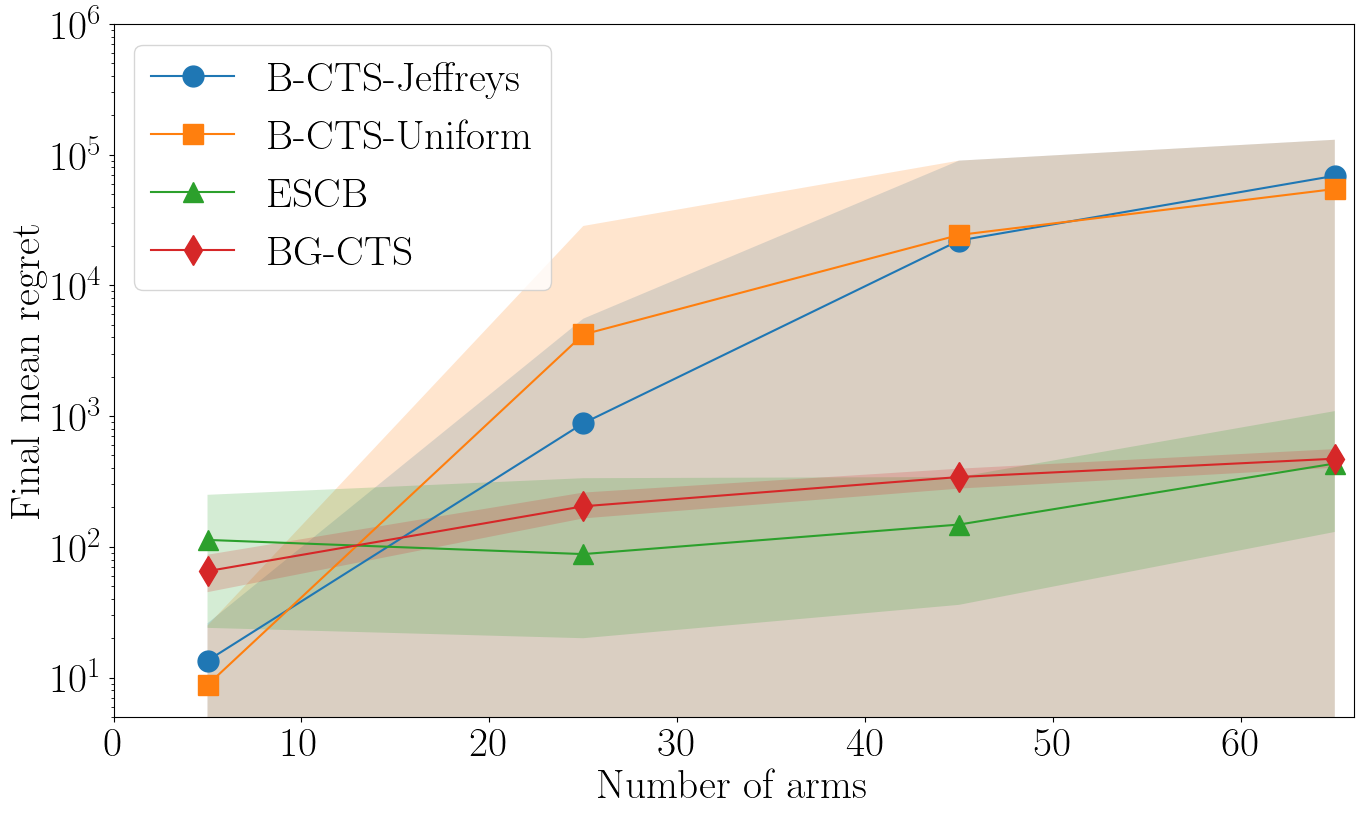

In [65]:
markers = ['o','s','^','d','+','*']
i = 0
ms = [i//2 for i in ds]
plt.figure(figsize=(16,9))

for key in regretsdict2:
    
    regrets = regretsdict2[key]
    cumregret = np.cumsum(regrets, axis = 2)

    finalregret = cumregret[:,:,-1]

    maxs = []
    mins = []
    means = []
    for di in range(lend):

        sorted = np.argsort(finalregret[di,:])
        std = np.std(finalregret, axis=1)

        worse = finalregret[di,sorted[int(0.95*N)]]
        best = finalregret[di,sorted[int(0.05*N)]]
        mean = np.mean(finalregret[di,:])

        means.append(mean)
        maxs.append(worse) 
        mins.append(best)

    plt.plot(ms,means, label=key, marker = markers[i], markersize = 15)
    plt.fill_between(ms, mins, maxs, alpha=0.2)
    i += 1
plt.xlabel("Number of arms")
plt.xticks(fontsize=30)
plt.ylabel("Final mean regret")
plt.yticks(fontsize=30)
plt.legend(loc='upper left', fontsize=30)
plt.yscale("log")
plt.ylim(bottom=5, top= 10**6)
plt.xlim(left = 0, right=66)
plt.savefig("finalmeanregret.png")